# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Structure of Notebook
0. Get to Know the Data
        1. General overview
        2. Missing values analysis and handling
        3. Additional Feature Engineering 
1. Customer Segmentation
        1. PCA
        1a) Fit PCA with 254 components
        2. KMEANS
        2a) Apply KMeans with selected number of clusters (9)
        3. Summary
    
2. Supervised Model
        1. Data preparation
        2. SMOTE
        3. Test of several models
        4. Fitting models
        
3. Prediction for Kaggle
        1. Data preparation
        2. Prediction
        3. Export


For a better notebook readability definitions of most functions related to data processing (mostly 1. part of the project) can be found in a separate file (utils.py).

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from utils import * #additional functions for data processing etc in a separate file for readability


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../data/Udacity_CUSTOMERS_052018.csv', sep=';')

/home/jakub/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Azdias dataset contains demographic data for German population. Customers data contains demographic data of Arvato's customers.

In order to avoid memory problems causing kernel to reset itself, the columns will be converted from int64 / float64 to int16/float16 respectively.
The remaning object columns will be dealt with in the next step.

In [3]:
azdias = change_types(azdias)

In [4]:
customers = change_types(customers)

### 1. General Overview 

In [5]:
azdias.shape, customers.shape

((891221, 366), (191652, 369))

A quick look at the table shows there are many missing values. Apart from that, inspection of the reference data shows many "-1" or "0" values should in fact be missing to. At a later point they will all be standardised and some then imputed.

In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


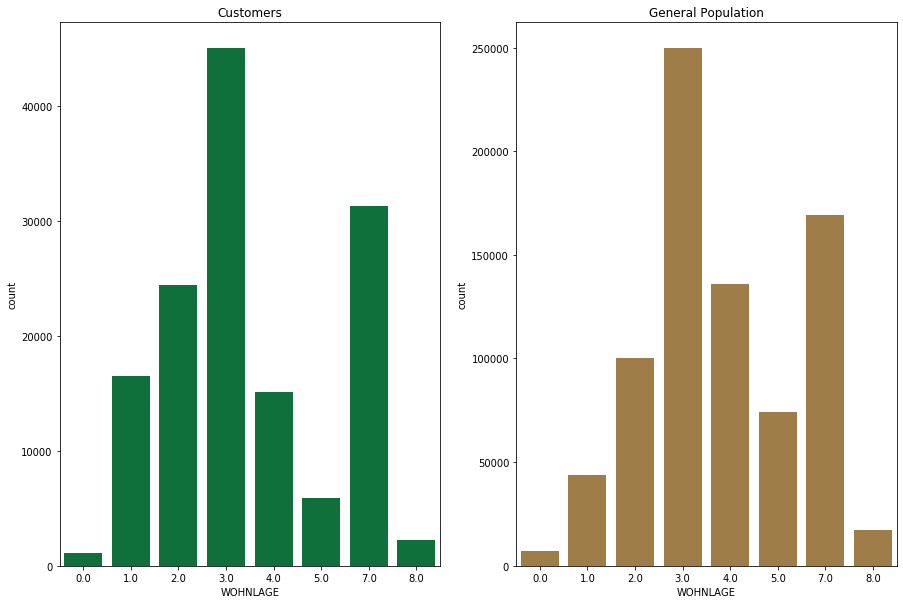

In [7]:
plot_column("WOHNLAGE", customers, azdias)

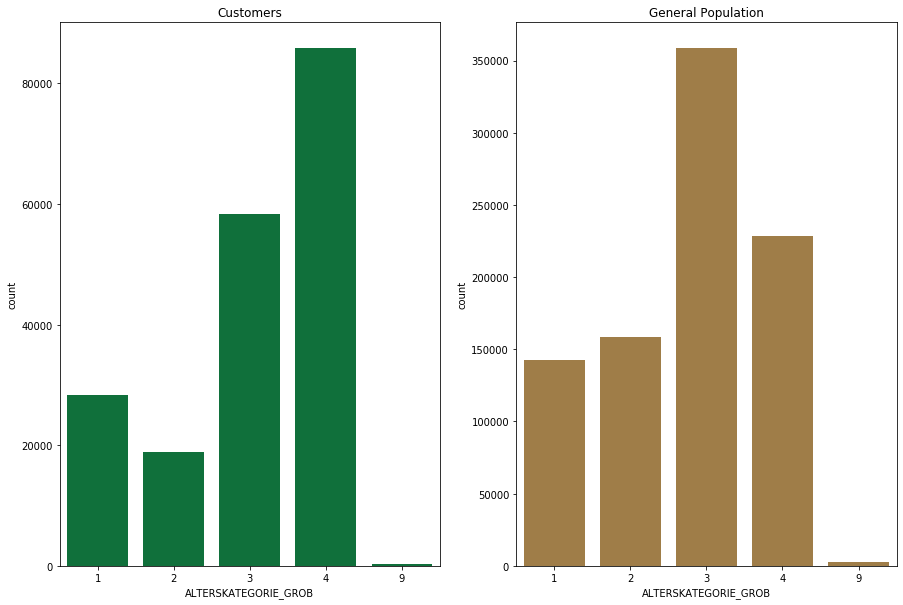

In [8]:
plot_column("ALTERSKATEGORIE_GROB", customers, azdias)

In [9]:
azdias.select_dtypes("object").columns

customers.select_dtypes("object").columns 

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')

In [10]:
azdias.dtypes.value_counts()

customers.dtypes.value_counts()

float16    267
int16       93
object       8
int64        1
dtype: int64

In [11]:
set(customers.columns.values) - set(azdias.columns.values)

print("There are", len(set(customers.columns.values) - set (azdias.columns.values)), "columns in customers that are not in azidas.")
print("They are", set(customers.columns.values) - set(azdias.columns.values) )

#Customer data contains 3 additional columns compared to azdias data (CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP)
#These columns won't be needed for that project.

There are 3 columns in customers that are not in azidas.
They are {'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'}


In [12]:
#all columns of azdias are in customers too 
set(azdias.columns.values) - set (customers.columns.values)

print("There are", len(set(azdias.columns.values) - set (customers.columns.values)), "columns in azidas that are not in customers.")

There are 0 columns in azidas that are not in customers.


In [13]:
if (len(set(azdias.LNR) - set(customers.LNR)) == azdias.LNR.nunique()) & (len(set(customers.LNR) - set(azdias.LNR)) == customers.LNR.nunique()):
    print("These data are separated from each other.")

These data are separated from each other.


Let's now take a look at the columns that seem to be of mixed type as shown by pandas warning during loading...

In [14]:
#names of the columns with mixed types (pandas warning during import)
azdias.columns[18:20]


Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [15]:
azdias.CAMEO_DEUG_2015.unique()


array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [16]:
azdias.CAMEO_INTL_2015.unique()


array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [17]:
customers.CAMEO_INTL_2015.unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

It seems like the warning came due to odd values 'X' and 'XX', they should be replaced with np.nan. In addition, some numeric values in these columns are encoded as strings.
Additionally the three columns that are unique only to customers data set are going to be removed.

In [18]:
azdias = solve_type_and_col_mismatch(azdias)

Mismatched columns  ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] were taken care of.
Column OST_WEST_KZ was recoded


In [19]:
customers = solve_type_and_col_mismatch(customers)

Mismatched columns  ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] were taken care of.
Column OST_WEST_KZ was recoded
Columns  {'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'} were removed from customers DataFrame.


### 2. Missing values analysis and handling

The next step will be checking whether the reference Excel data included for this project contains information on all available attributes.

Check if all attributes are mentioned in the reference as this can be important for missing handling or decision if any unknown features should remain in the data for later analysis.

Additionally during values check, I spotted some naming convention differences with regards to CAMEO, SOHO and D19 variables ("_RZ" is only used as suffix in 'DIAS Attributes' file) 

In [20]:
dias = pd.read_excel("../data/DIAS Attributes - Values 2017.xlsx", header=1)
dias = dias.fillna(method='ffill')
dias.head()
dias = dias.replace({"CAMEO_DEUINTL_2015":"CAMEO_INTL_2015", "SOHO_FLAG":"SOHO_KZ", "D19_BUCH":"D19_BUCH_CD"})
dias['Attribute'] = dias['Attribute'].map(lambda x: x.replace("_RZ", ""))


A quick look at values of "Meaning" column shows 2 things: 
- many values refer to 'unknown' 
- More than 150 variables are encoded on an interval scale ("low", "high", et cetera).

In [21]:
dias.Meaning.value_counts()

unknown                            232
average                            162
low                                154
high                               154
very high                          142
                                  ... 
10.001 to 20.000 inhabitants         1
high car quote                       1
01.01.1920 bis 31.12.1924            1
residential cell                     1
high share of 6-10 family homes      1
Name: Meaning, Length: 538, dtype: int64

In [22]:
doku_attrs = dias.Attribute.unique()

In [23]:
len(set(doku_attrs) - set(azdias.columns))

# {'BIP_FLAG',
#  'D19_BUCH',
#  'D19_KK_KUNDENTYP',
#  'GEOSCORE_KLS7',
#  'HAUSHALTSSTRUKTUR',
#  'KBA13_CCM_1400_2500',
#  'WACHSTUMSGEBIET_NB'}
#unknown matching, so lets leave it 

7

In [24]:
len(set(azdias.columns) - set(doku_attrs))


59

In [25]:
print("There are descriptions available for", len(doku_attrs), "attributes, however the azdias data has", len(azdias.columns), "attributes")

There are descriptions available for 314 attributes, however the azdias data has 366 attributes


In [26]:
nondoku_attrs = [c for c in azdias.columns if c not in doku_attrs]
len(nondoku_attrs)

59

Now I will create a dictionary containing given values for NANs so that all NANs of the data will be standarized and can be scrutinized.

In [27]:
na_phrases = ["unknown", "no transaction known", "no transactions known"]
unknowns = dias[dias["Meaning"].str.contains('|'.join(na_phrases), na=False)]
unknowns.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
40,NaN,BALLRAUM,distance to next urban centre,-1,unknown


In [28]:
nan_doku_dict = unknowns.set_index('Attribute')['Value'].to_dict()

In [29]:
nan_doku_dict  = dict_for_replace(nan_doku_dict)

In [30]:
nan_nondoku_dict = {k: {-1: np.nan} for k in nondoku_attrs}

In [31]:
nan_dict = {**nan_doku_dict, **nan_nondoku_dict }

In [32]:
nan_dict

{'AGER_TYP': {-1: nan},
 'ALTERSKATEGORIE_GROB': {-1: nan, 0: nan},
 'ALTER_HH': {0: nan},
 'ANREDE_KZ': {-1: nan, 0: nan},
 'BALLRAUM': {-1: nan},
 'BIP_FLAG': {-1: nan},
 'CAMEO_DEUG_2015': {-1: nan},
 'CAMEO_INTL_2015': {-1: nan},
 'CJT_GESAMTTYP': {0: nan},
 'D19_BANKEN_ANZ_12': {0: nan},
 'D19_BANKEN_ANZ_24': {0: nan},
 'D19_BANKEN_DATUM': {10: nan},
 'D19_BANKEN_DIREKT': {0: nan},
 'D19_BANKEN_GROSS': {0: nan},
 'D19_BANKEN_LOKAL': {0: nan},
 'D19_BANKEN_OFFLINE_DATUM': {10: nan},
 'D19_BANKEN_ONLINE_DATUM': {10: nan},
 'D19_BANKEN_REST': {0: nan},
 'D19_BEKLEIDUNG_GEH': {0: nan},
 'D19_BEKLEIDUNG_REST': {0: nan},
 'D19_BILDUNG': {0: nan},
 'D19_BIO_OEKO': {0: nan},
 'D19_BUCH': {0: nan},
 'D19_DIGIT_SERV': {0: nan},
 'D19_DROGERIEARTIKEL': {0: nan},
 'D19_ENERGIE': {0: nan},
 'D19_FREIZEIT': {0: nan},
 'D19_GARTEN': {0: nan},
 'D19_GESAMT_ANZ_12': {0: nan},
 'D19_GESAMT_ANZ_24': {0: nan},
 'D19_GESAMT_DATUM': {10: nan},
 'D19_GESAMT_OFFLINE_DATUM': {10: nan},
 'D19_GESAMT_ONLINE

By invoking the all_missings_to_nans() function on both datasets with passing just created nan_dict dictionary all missing values are shown as NAN.

In [33]:
azdias_cleaned = all_missings_to_nans(azdias, nan_dict)


In [34]:
customers_cleaned = all_missings_to_nans(customers, nan_dict)



In [35]:
#CHECK WHATS ROW AND WHATS COL!!!!!!

In [36]:
azdias_perc_missing_rows = azdias_cleaned.isnull().sum(axis=1)*100/len(azdias_cleaned.columns)


Text(0.5, 1.0, 'Number of  rows by percentage of missing values')

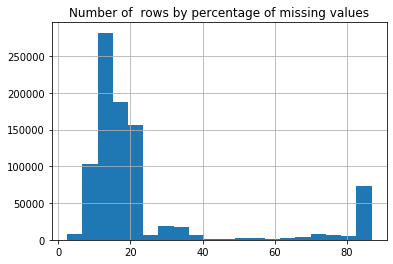

In [37]:
azdias_perc_missing_rows.hist(bins=20) 
plt.title("Number of  rows by percentage of missing values")

Based on the above plot it seems most rows have no more than 20% missings. 

In [38]:
azdias_perc_missing_cols = azdias_cleaned.isnull().sum(axis=0)*100/len(azdias_cleaned)


Text(0.5, 1.0, 'Number of columns by percentage of missing values')

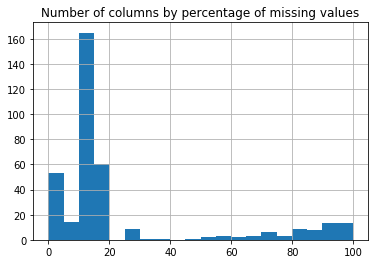

In [39]:
azdias_perc_missing_cols.hist(bins=20) #add titles and shieeet
plt.title("Number of columns by percentage of missing values")

Similarily as in case of columns, there seem to be many rows with no more than 20% missing values, but there is also plenty of them in the 80-100% range. These should be removed as they deliver no info at all. 

Let's get some textual description of missings.

In [40]:
summary_of_missings(azdias_cleaned, rows = 1)

There are 891221 rows in total in the dataframe
There are 891221 rows with more than 0 % missings in the dataframe ( 1.0 )
There are 817228 rows with more than 10 % missings in the dataframe ( 0.92 )
There are 217309 rows with more than 20 % missings in the dataframe ( 0.24 )
There are 139618 rows with more than 30 % missings in the dataframe ( 0.16 )
There are 106212 rows with more than 40 % missings in the dataframe ( 0.12 )
There are 103235 rows with more than 50 % missings in the dataframe ( 0.12 )
There are 99746 rows with more than 60 % missings in the dataframe ( 0.11 )
There are 92402 rows with more than 70 % missings in the dataframe ( 0.1 )
There are 76848 rows with more than 80 % missings in the dataframe ( 0.09 )
There are 0 rows with more than 90 % missings in the dataframe ( 0.0 )


In [41]:
summary_of_missings(customers_cleaned, rows = 1)

There are 191652 rows in total in the dataframe
There are 191652 rows with more than 0 % missings in the dataframe ( 1.0 )
There are 165976 rows with more than 10 % missings in the dataframe ( 0.87 )
There are 58607 rows with more than 20 % missings in the dataframe ( 0.31 )
There are 54801 rows with more than 30 % missings in the dataframe ( 0.29 )
There are 51293 rows with more than 40 % missings in the dataframe ( 0.27 )
There are 50878 rows with more than 50 % missings in the dataframe ( 0.27 )
There are 50748 rows with more than 60 % missings in the dataframe ( 0.26 )
There are 49338 rows with more than 70 % missings in the dataframe ( 0.26 )
There are 46647 rows with more than 80 % missings in the dataframe ( 0.24 )
There are 0 rows with more than 90 % missings in the dataframe ( 0.0 )


From both dataframes I will remove all rows which have more than half of their values missing and then let's check summary of missing columns in the new dataframes.

In [42]:
azdias_cleaned_n = remove_rows_with_too_much_nan(azdias_cleaned, 0.5)

Rows before removing  891221
New table with 787850 rows created


In [43]:
customers_cleaned_n = remove_rows_with_too_much_nan(customers_cleaned, 0.5)

Rows before removing  191652
New table with 140759 rows created


In [44]:
summary_of_missings(azdias_cleaned_n, rows = 0)

There are 366 cols in total in the dataframe
There are 313 cols with more than 0 % missings in the dataframe ( 0.86 )
There are 74 cols with more than 10 % missings in the dataframe ( 0.2 )
There are 74 cols with more than 20 % missings in the dataframe ( 0.2 )
There are 64 cols with more than 30 % missings in the dataframe ( 0.17 )
There are 63 cols with more than 40 % missings in the dataframe ( 0.17 )
There are 60 cols with more than 50 % missings in the dataframe ( 0.16 )
There are 55 cols with more than 60 % missings in the dataframe ( 0.15 )
There are 49 cols with more than 70 % missings in the dataframe ( 0.13 )
There are 40 cols with more than 80 % missings in the dataframe ( 0.11 )
There are 23 cols with more than 90 % missings in the dataframe ( 0.06 )


In [45]:
summary_of_missings(customers_cleaned_n, rows = 0)

There are 366 cols in total in the dataframe
There are 310 cols with more than 0 % missings in the dataframe ( 0.85 )
There are 64 cols with more than 10 % missings in the dataframe ( 0.17 )
There are 62 cols with more than 20 % missings in the dataframe ( 0.17 )
There are 58 cols with more than 30 % missings in the dataframe ( 0.16 )
There are 53 cols with more than 40 % missings in the dataframe ( 0.14 )
There are 48 cols with more than 50 % missings in the dataframe ( 0.13 )
There are 46 cols with more than 60 % missings in the dataframe ( 0.13 )
There are 39 cols with more than 70 % missings in the dataframe ( 0.11 )
There are 30 cols with more than 80 % missings in the dataframe ( 0.08 )
There are 15 cols with more than 90 % missings in the dataframe ( 0.04 )


Judging by the way missing values are distributed among columns, I decided to set a cutoff point at 30%, meaning 64 columns of azdias are going to be removed from further analysis as a result of significant number of missing values. 

For additional inspection a missing_df dataframe was created that shows which columns belong to which missing % bracket in both dataframes.

In [46]:
missing_df = calculate_perc_missings(customers_cleaned_n, azdias_cleaned_n, perc_treshold = 0.3)


In [47]:
missing_df.head()

,perc_missing_customer_df,perc_missing_azdias_df,flag_customer,flag_azdias,missing_mismatch
Variable,,,,,
ALTER_KIND4,0.998345,0.998516,True,True,False
TITEL_KZ,0.984029,0.997379,True,True,False
ALTER_KIND3,0.991212,0.992383,True,True,False
D19_TELKO_ONLINE_DATUM,0.985386,0.990001,True,True,False
D19_BANKEN_LOKAL,0.970631,0.979878,True,True,False


There are 6 columns that exceed the 30%-missing-treshold in azdias but not in customers. They'll be kept.

In [48]:
missing_df[missing_df.missing_mismatch]

,perc_missing_customer_df,perc_missing_azdias_df,flag_customer,flag_azdias,missing_mismatch
Variable,,,,,
EXTSEL992,0.264253,0.707371,False,True,True
D19_GESAMT_OFFLINE_DATUM,0.293914,0.591237,False,True,True
D19_SONSTIGE,0.205443,0.526332,False,True,True
D19_GESAMT_ONLINE_DATUM,0.298127,0.460102,False,True,True
D19_VERSAND_DATUM,0.182823,0.443781,False,True,True
D19_GESAMT_DATUM,0.095767,0.341078,False,True,True


Text(0.5, 1.0, 'Columns with biggest missing values ratio for both datasets (azdias perspective)')

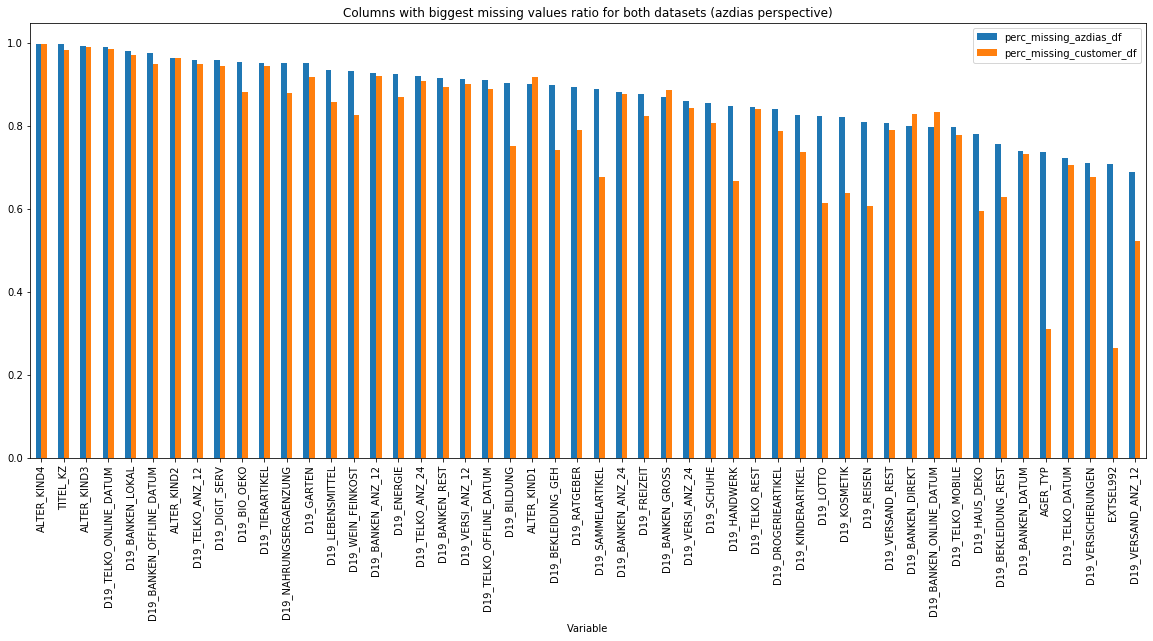

In [49]:
missing_df[["perc_missing_azdias_df", "perc_missing_customer_df"]][:50].plot(kind='bar', figsize=(20,8), fontsize=10)
plt.title("Columns with biggest missing values ratio for both datasets (azdias perspective)")


Text(0.5, 1.0, 'Columns with biggest missing values ratio for both datasets (customers perspective)')

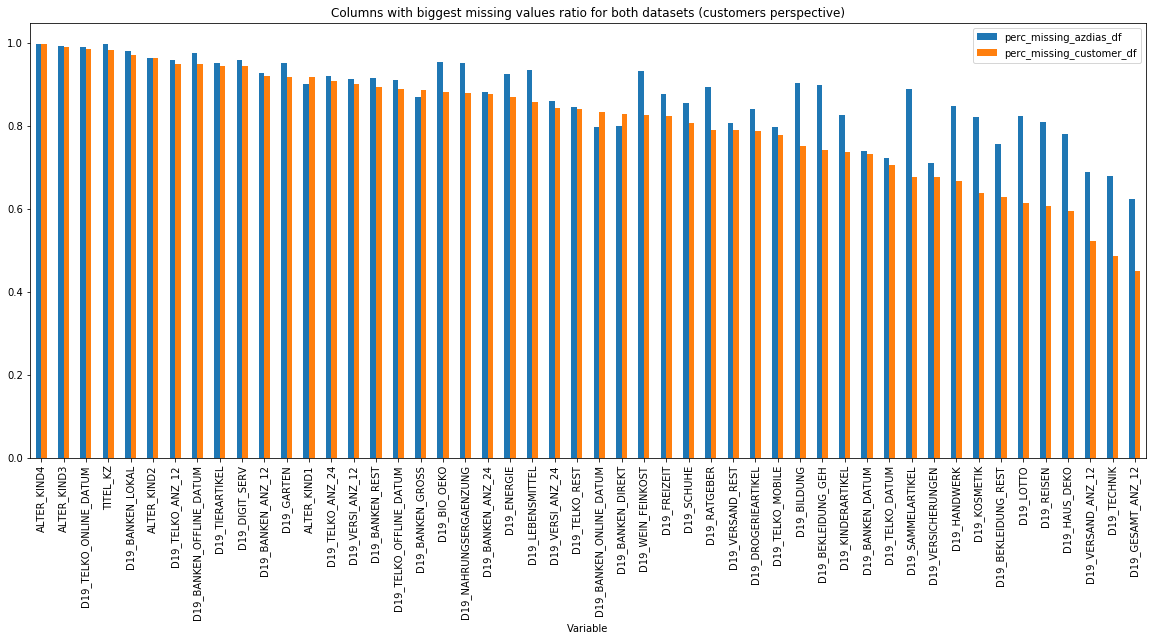

In [50]:
missing_df.sort_values(["perc_missing_customer_df", "perc_missing_azdias_df"], ascending=[False, False])[["perc_missing_azdias_df", "perc_missing_customer_df"]][:50].plot(kind='bar', figsize=(20,8), fontsize=10)

plt.title("Columns with biggest missing values ratio for both datasets (customers perspective)")


In [51]:
len(missing_df[missing_df.perc_missing_azdias_df > 0.3])

64

In [52]:
azdias_cleaned_n = drop_cols(azdias_cleaned_n, missing_df, 0.3)

In [53]:
customers_cleaned_n = drop_cols(customers_cleaned_n, missing_df, 0.3)

In [54]:
azdias_cleaned_n.shape

(787850, 308)

In [55]:
customers_cleaned_n.shape

(140759, 308)

In [56]:
azdias_cleaned_n.dtypes.value_counts()

float16    259
int16       32
float64     13
object       3
int64        1
dtype: int64

Object columns will be taken care of during feature engineering step

In [57]:
azdias_cleaned_n.select_dtypes("object")

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
1,8A,NaN,1992-02-10 00:00:00
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00
4,6B,D19_SCHUHE,1992-02-12 00:00:00
5,8C,D19_ENERGIE,1992-02-12 00:00:00
...,...,...,...
891216,7A,D19_HAUS_DEKO,1992-02-10 00:00:00
891217,9D,D19_UNBEKANNT,1992-02-10 00:00:00
891218,4C,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00
891219,9D,D19_UNBEKANNT,1992-02-12 00:00:00


In [58]:
customers_cleaned_n.select_dtypes("object")

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
0,1A,D19_UNBEKANNT,1992-02-12 00:00:00
2,5D,D19_UNBEKANNT,1992-02-10 00:00:00
3,4C,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00
4,7B,D19_SCHUHE,1992-02-12 00:00:00
5,5D,D19_BUCH_CD,1992-02-10 00:00:00
...,...,...,...
191647,1C,D19_BANKEN_REST,1992-02-10 00:00:00
191648,5B,D19_UNBEKANNT,1997-03-06 00:00:00
191649,4D,D19_TECHNIK,1992-02-10 00:00:00
191650,4C,D19_BANKEN_REST,1992-02-10 00:00:00


In [59]:
customers_cleaned_n.columns[customers_cleaned_n.isnull().any(axis=0)]

Index(['ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'ANZ_HH_TITEL', 'ARBEIT',
       'BALLRAUM', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER',
       ...
       'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11',
       'W_KEIT_KIND_HH'],
      dtype='object', length=252)

Next step is to impute missing values using "most frequent value" logic (details in function definition in file utils.py):

In [60]:
#clear memory
del azdias
del customers
del azdias_cleaned
del customers_cleaned

In [61]:
azdias_no_missings = impute_missings(azdias_cleaned_n)

In [62]:
customers_no_missings = impute_missings(customers_cleaned_n)

In [65]:
customers_no_missings.isna().sum().sum() == azdias_no_missings.isna().sum().sum()


True

In [66]:
azdias_no_missings.isna().sum().sum()

0

In [67]:
customers_no_missings.shape

(140759, 308)

### 3. Additional feeature engineering 

After inspecting and cleaning the data next step is to create new features as well as encode existing categorical variables to form that can be understood by machine learning algorithms (one-hot-encoding).

In [68]:
azdias_feat = process_and_generate_features(azdias_no_missings)


In [69]:
customers_feat = process_and_generate_features(customers_no_missings)

In [70]:
customers_feat.isna().sum().sum()

0

In [71]:
azdias_feat.shape, customers_feat.shape

((787850, 408), (140759, 408))

As a result of adding features and one hot encoding of categorical variables, there were 100 new columns generated



In [72]:
set(azdias_feat.columns) - set(customers_feat.columns) 

set()

In [78]:
#save data for next parts.
azdias_feat.to_csv('../data/Azdias_cleaned_50_30_MF.csv', index=False)
customers_feat.to_csv('../data/Customers_cleaned_50_30_MF.csv', index=False)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1. PCA

In [79]:
#SCALE FEATURES & PCAIZE

In [73]:
azdias_feat = pd.read_csv('../data/Azdias_cleaned_50_30_MF.csv')
azdias_feat = change_types(azdias_feat)




In [74]:
azdias_feat.dtypes.value_counts()

float16    258
int16      150
dtype: int64

In [75]:
customers_feat = pd.read_csv('../data/Customers_cleaned_50_30_MF.csv')
customers_feat = change_types(customers_feat)

In [76]:
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_feat)




In [77]:
features_list = azdias_feat.columns

In [78]:
azdias_scaled

array([[ 1.2630744 ,  0.56206316,  1.559351  , ...,  1.4115629 ,
        -0.5311243 ,  0.5311243 ],
       [ 1.2630744 ,  0.27117798,  0.66958594, ..., -0.7084346 ,
         1.8827986 , -1.8827986 ],
       [-0.9360725 , -0.89236265, -0.22017916, ..., -0.7084346 ,
        -0.5311243 ,  0.5311243 ],
       ...,
       [-0.9360725 ,  0.27117798,  0.66958594, ..., -0.7084346 ,
        -0.5311243 ,  0.5311243 ],
       [ 1.2630744 ,  0.56206316,  1.3369098 , ...,  1.4115629 ,
        -0.5311243 ,  0.5311243 ],
       [-0.9360725 ,  0.56206316,  0.22470339, ..., -0.7084346 ,
        -0.5311243 ,  0.5311243 ]], dtype=float32)

In [79]:
azdias_scaled = pd.DataFrame(azdias_scaled)
azdias_scaled.columns = features_list

In [80]:
azdias_scaled.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,ZABEOTYP_5,ZABEOTYP_6,LP_STATUS_GROB_NEU_1,LP_STATUS_GROB_NEU_2,LP_FAMILIE_GROB_NEU_0,LP_FAMILIE_GROB_NEU_1,LP_FAMILIE_GROB_NEU_2,LP_FAMILIE_GROB_NEU_3,PRAEGENDE_JUGENDJAHRE_MAINSTREAM_0,PRAEGENDE_JUGENDJAHRE_MAINSTREAM_1
0,1.263074,0.562063,1.559351,0.173517,-0.12525,-0.307046,0.230259,0.308510,-0.060492,-0.173938,...,2.971666,-0.312533,0.783092,-0.783092,-0.186066,-1.017941,-0.375334,1.411563,-0.531124,0.531124
1,1.263074,0.271178,0.669586,0.109339,-0.12525,-0.307046,-0.632257,-0.042177,-0.060492,-0.173938,...,2.971666,-0.312533,0.783092,-0.783092,-0.186066,0.982375,-0.375334,-0.708435,1.882799,-1.882799
2,-0.936073,-0.892363,-0.220179,-0.468258,-0.12525,-0.307046,-1.494773,-0.392865,-0.060492,-1.173065,...,-0.336512,-0.312533,-1.276989,1.276989,5.374448,-1.017941,-0.375334,-0.708435,-0.531124,0.531124
3,-0.936073,1.143833,0.002262,-0.339903,-0.12525,-0.307046,1.955290,-0.322727,-0.060492,0.825189,...,-0.336512,-0.312533,0.783092,-0.783092,-0.186066,-1.017941,-0.375334,1.411563,-0.531124,0.531124
4,-0.936073,-1.765018,-0.887503,-0.211548,-0.12525,-0.307046,-0.632257,-0.392865,-0.060492,-1.173065,...,-0.336512,-0.312533,0.783092,-0.783092,-0.186066,0.982375,-0.375334,-0.708435,-0.531124,0.531124


In [81]:
customers_scaled = scaler.fit_transform(customers_feat)
customers_scaled = pd.DataFrame(customers_scaled)
customers_scaled.columns = features_list

In [82]:
customers_scaled.head()



,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,ZABEOTYP_5,ZABEOTYP_6,LP_STATUS_GROB_NEU_1,LP_STATUS_GROB_NEU_2,LP_FAMILIE_GROB_NEU_0,LP_FAMILIE_GROB_NEU_1,LP_FAMILIE_GROB_NEU_2,LP_FAMILIE_GROB_NEU_3,PRAEGENDE_JUGENDJAHRE_MAINSTREAM_0,PRAEGENDE_JUGENDJAHRE_MAINSTREAM_1
0,-0.376477,-0.685584,-0.075323,-0.277048,-0.123449,-0.275963,-0.196448,-0.261004,-0.133785,-1.807488,...,-0.082824,-0.195092,-0.615742,0.615742,-0.214437,-0.610773,2.047005,-0.983491,0.985674,-0.985674
1,-0.376477,-1.636940,-2.539663,-0.277048,-0.123449,-0.275963,-0.914545,-0.261004,-0.133785,0.172212,...,-0.082824,-0.195092,-0.615742,0.615742,-0.214437,1.637268,-0.488519,-0.983491,0.985674,-0.985674
2,-0.376477,-1.161262,-0.568191,-0.347296,-0.123449,-0.275963,-1.632642,-0.261004,-0.133785,-1.807488,...,-0.082824,-0.195092,-0.615742,0.615742,4.663378,-0.610773,-0.488519,-0.983491,-1.014535,1.014535
3,-0.376477,1.692804,0.910414,0.144438,-0.123449,-0.275963,1.239747,0.164260,-0.133785,0.172212,...,-0.082824,-0.195092,1.624056,-1.624056,-0.214437,-0.610773,-0.488519,1.016786,-1.014535,1.014535
4,-0.376477,-0.447745,-0.075323,-0.277048,-0.123449,-0.275963,-0.196448,-0.261004,-0.133785,0.172212,...,-0.082824,-0.195092,-0.615742,0.615742,-0.214437,-0.610773,2.047005,-0.983491,0.985674,-0.985674


In [83]:
len(azdias_scaled.columns.values) == len(customers_scaled.columns.values)

True

In [84]:
n_components_azdias = len(azdias_scaled.columns.values)
#n_components_customers = len(customers_scaled.columns.values)

In [85]:
pca = PCA(n_components_azdias)

In [86]:
azdias_pca = pca.fit(azdias_scaled)

In [87]:
exp_variance = azdias_pca.explained_variance_ratio_


In [89]:
exp_variance[0] #first component explains 7.3% of variability in azdias data

0.07323880403675674

In [90]:
# cumulated sum to plot it - has to go to 100%

In [91]:
cumsum_variance=np.cumsum(np.round(exp_variance, decimals=3)*100)

In [92]:
n_components = len(exp_variance)
n_components

408

In [93]:
for checkpoint in np.arange(1,n_components,15):
    print(checkpoint, "components explain", round(sum(exp_variance[:checkpoint])*100,2), "% of variance in azdias")

1 components explain 7.32 % of variance in azdias
16 components explain 35.3 % of variance in azdias
31 components explain 45.44 % of variance in azdias
46 components explain 52.5 % of variance in azdias
61 components explain 58.23 % of variance in azdias
76 components explain 63.05 % of variance in azdias
91 components explain 67.28 % of variance in azdias
106 components explain 71.17 % of variance in azdias
121 components explain 74.87 % of variance in azdias
136 components explain 78.37 % of variance in azdias
151 components explain 81.54 % of variance in azdias
166 components explain 84.39 % of variance in azdias
181 components explain 86.92 % of variance in azdias
196 components explain 89.15 % of variance in azdias
211 components explain 91.12 % of variance in azdias
226 components explain 92.78 % of variance in azdias
241 components explain 94.17 % of variance in azdias
256 components explain 95.36 % of variance in azdias
271 components explain 96.37 % of variance in azdias
286 

Text(0.5, 1.0, 'PCA results')

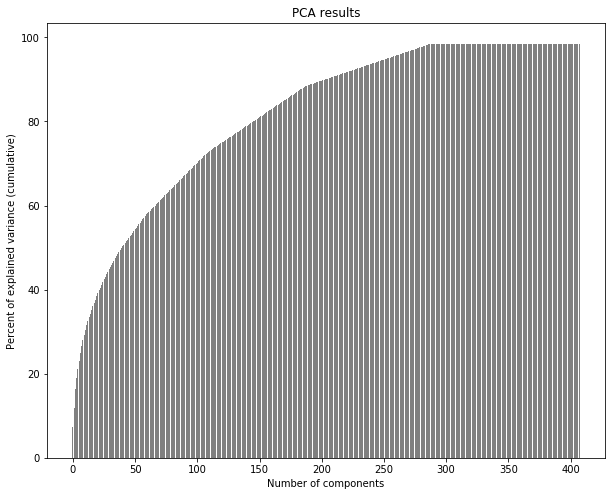

In [94]:
index = np.arange(n_components)


plt.figure(figsize=(10,8))
plt.bar(index, cumsum_variance, color="gray")

plt.ylabel('Percent of explained variance (cumulative)')
plt.xlabel('Number of components')
plt.title('PCA results')



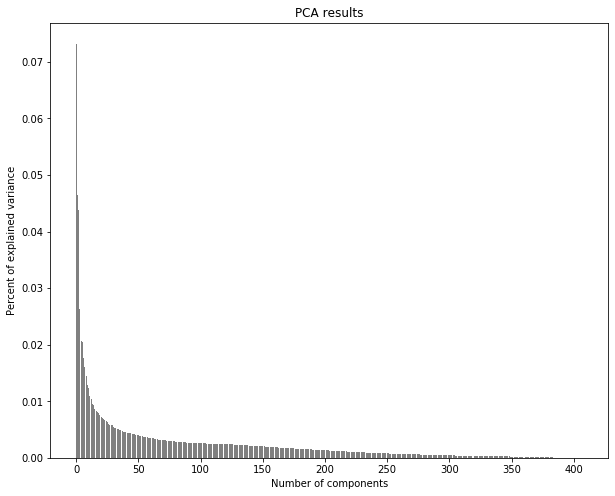

In [95]:
plt.figure(figsize=(10,8))

plt.bar(index, exp_variance, color="gray")
plt.xlabel('Number of components')
plt.ylabel('Percent of explained variance')
plt.title('PCA results');

In [106]:
#.searchsorted -> https://stackoverflow.com/questions/38620741/a-fast-numpy-way-to-find-index-in-array-where-cumulative-sum-becomes-greater#comment64627558_38620741
index = cumsum_variance.searchsorted(95)
index

254

In [109]:
cumsum_variance[254]

95.09999999999968

Based on both textual summary as well as graphical representation of the PCA results I decided to apply PCA with 254 components which explain over 95% of variation in the imput data.

### 1a) Fitting PCA with 254 components

In [110]:
pca = PCA(254)


In [111]:
azdias_pca = pca.fit_transform(azdias_scaled)

### 2 KMEANS 

In [112]:
def get_kmeans_score(data, n_clust):
    """Function returns the SSE score for given number of clusters in KMeans model fitted on data.
    INPUT:
        data (pd.DataFrame) - dataset to fit the KMeans on
        n_clust (int) -  number of clusters
    OUTPUT:
        score (float) - the SSE score for the kmeans model fit to the data
    """
    kmeans = KMeans(n_clusters=n_clust, random_state=42)

    fitted = kmeans.fit(data)
    
    score = np.abs(fitted.score(data))
    
    return score


In [113]:
score_list = []
n_clusters = np.arange(6, 18, 1)
n_clusters

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [115]:
for num in n_clusters: 
    current_score = get_kmeans_score(azdias_pca, num)
    print(current_score)
    score_list.append(current_score)

268472768.0
265693408.0
263497184.0
261450480.0
259911280.0
258695632.0
257554976.0
256444064.0
255335744.0
254381472.0
253353984.0
252564048.0


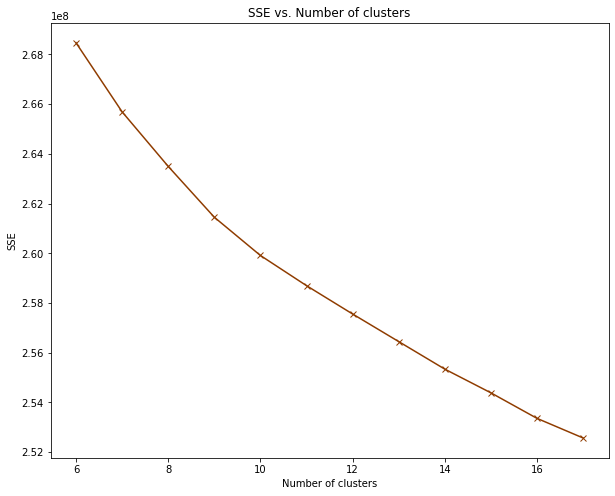

In [125]:
plt.figure(figsize=(10,8))
plt.plot(n_clusters, score_list,  marker='x', color='#8f3c00');
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('SSE vs. Number of clusters')
plt.show()

It looks like 9 can be a good number of clusters as the decrease of SSE from there onwards seems to be slower.

### 2a) Apply KMeans with selected number of clusters (9) 

In [126]:
def calculate_cluster_occurences(labels, source, ratios=True ):
    """Function returns a pandas DataFrame containing info on cluster and either ratio or number of data elements belonging to that cluster.
    INPUT:
        labels (np.array) -  output of kmeans.fit_predict or kmeans.predict
        source (string) - identifier of the dataset (customers or general population)
        ratios (Boolean) - if True Ratios will be calculated, otherwise number
    OUTPUT: 
        df_calc (pd.DataFrame) - table with calculated proportions or number of occurences for each cluster"""
    
    calc = dict(zip(*np.unique(labels, return_counts=True)))
    if ratios==True:
        for k, v in calc.items():
            calc[k] = 100*v / len(labels)
            
    df_calc = pd.DataFrame(list(calc.items()), [source for c in range(len(calc))], columns = ["Cluster", "Value"])  #Value
    
    return df_calc
    

In [127]:
kmeans = KMeans(n_clusters=9, random_state=23)

labels_azdias = kmeans.fit_predict(azdias_pca)

In [128]:
customers_pca = pca.transform(customers_scaled)

In [129]:
labels_customers = kmeans.predict(customers_pca)

In [130]:
calculate_cluster_occurences(labels_azdias, "General Population", False)

,Cluster,Value
General Population,0,98804
General Population,1,117843
General Population,2,57051
General Population,3,86519
General Population,4,114339
General Population,5,55614
General Population,6,54900
General Population,7,99875
General Population,8,102905


In [131]:
df_clust_azdias = calculate_cluster_occurences(labels_azdias, "General Population")
df_clust_azdias

,Cluster,Value
General Population,0,12.540966
General Population,1,14.957543
General Population,2,7.241353
General Population,3,10.981659
General Population,4,14.512788
General Population,5,7.058958
General Population,6,6.968332
General Population,7,12.676906
General Population,8,13.061496


In [132]:
df_clust_cust = calculate_cluster_occurences(labels_customers, "Customers")
df_clust_cust

,Cluster,Value
Customers,0,7.762203
Customers,1,17.726042
Customers,2,9.694584
Customers,3,15.613922
Customers,4,7.614433
Customers,5,3.466208
Customers,6,4.460816
Customers,7,14.104249
Customers,8,19.557542


In [133]:
df_clust_ratios = df_clust_azdias.append(df_clust_cust).reset_index()
df_clust_ratios

,index,Cluster,Value
0,General Population,0,12.540966
1,General Population,1,14.957543
2,General Population,2,7.241353
3,General Population,3,10.981659
4,General Population,4,14.512788
5,General Population,5,7.058958
6,General Population,6,6.968332
7,General Population,7,12.676906
8,General Population,8,13.061496
9,Customers,0,7.762203


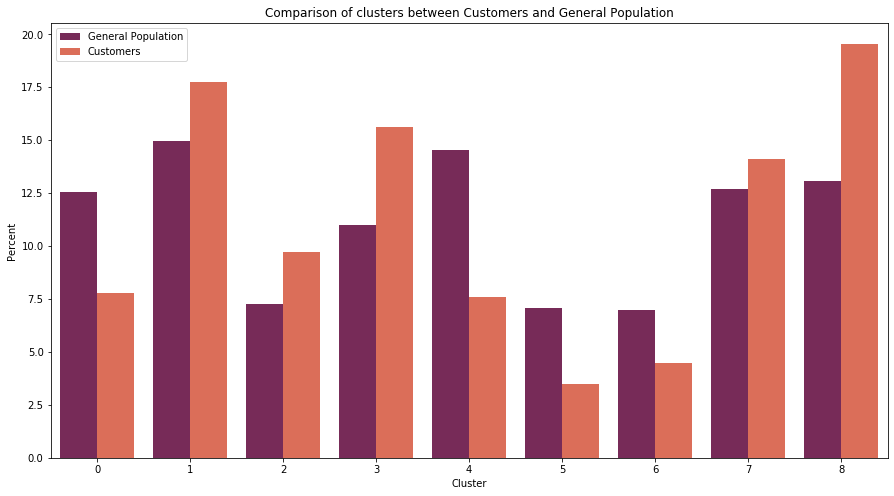

In [136]:
plt.figure(figsize=(15, 8))
sns.barplot(x="Cluster", y="Value", hue="index", data=df_clust_ratios, palette="rocket")
plt.xlabel('Cluster')
plt.ylabel('Percent')
plt.title('Comparison of clusters between Customers and General Population')
plt.legend()
plt.show()

From the above plot we can see the populations differ substancially when it comes to the clusters distribution. Among the clusters 1,2,3,7,8 there are more customers than in the general population. 

In [137]:
df_clust_cust

,Cluster,Value
Customers,0,7.762203
Customers,1,17.726042
Customers,2,9.694584
Customers,3,15.613922
Customers,4,7.614433
Customers,5,3.466208
Customers,6,4.460816
Customers,7,14.104249
Customers,8,19.557542


In [141]:
df_clust_joined = df_clust_cust.merge(df_clust_azdias, on = "Cluster").rename({"Value_x":"Percentage_Customers", "Value_y":"Percentage_General_Population"}, axis=1)


In [146]:
df_clust_joined["Change_factor"] = (df_clust_joined["Percentage_Customers"]/df_clust_joined["Percentage_General_Population"])-1
df_clust_joined.sort_values(by="Change_factor", ascending=False)

,Cluster,Percentage_Customers,Percentage_General_Population,Change_factor
8,8,19.557542,13.061496,0.497343
3,3,15.613922,10.981659,0.421818
2,2,9.694584,7.241353,0.338781
1,1,17.726042,14.957543,0.185091
7,7,14.104249,12.676906,0.112594
6,6,4.460816,6.968332,-0.359844
0,0,7.762203,12.540966,-0.381052
4,4,7.614433,14.512788,-0.475329
5,5,3.466208,7.058958,-0.508963


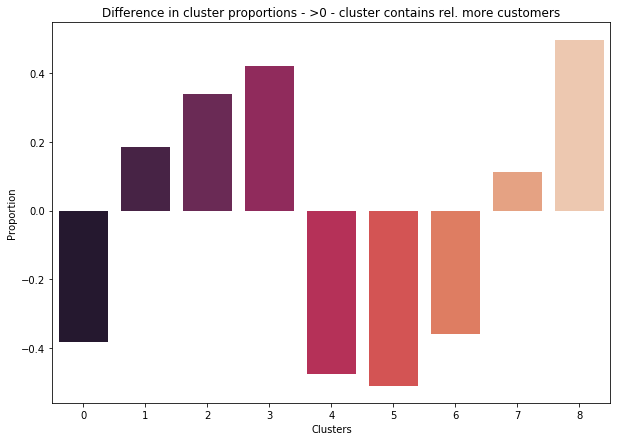

In [147]:
fig = plt.figure(figsize=(10,7))
ax = sns.barplot(x = df_clust_joined['Cluster'], y = df_clust_joined['Change_factor'], palette="rocket")
ax.set(title=f'Difference in cluster proportions - >0 - cluster contains rel. more customers', ylabel='Proportion', xlabel='Clusters');


### 3. Summary

Now let's find out which attributes are more associated with the two main separating clusters (8 for customers and 5 for the general population)

In [148]:
def get_cluster_feature_summary(cluster_cust, cluster_pop, df=azdias_scaled, pca=pca, kmeans=kmeans):
    """Function returns a pandas DataFrame containing info on features and their position within cluster.
    INPUT:
        cluster_cust (int) -  number of cluster with higher proportion of individuals in customers data
        cluster_pop (int) - number of cluster with higher proportion of individuals in general population data
        df (pd.DataFrame) - dataframe used to obtain column names (either customers or general population)
        pca (PCA) - fitted PCA
        kmeans (K-Means) - fitted K-Means model
    OUTPUT: 
        data (pd.DataFrame) - pandas DataFrame with features & their values in center of respective cluster"""
    
    center_customers = kmeans.cluster_centers_[cluster_cust]
    center_general = kmeans.cluster_centers_[cluster_pop]
    
    center_customers_inv = pca.inverse_transform(center_customers)
    center_general_inv = pca.inverse_transform(center_general)
    
    feature_names = df.columns

    data = pd.DataFrame({"feature" : feature_names, "cluster_customers_center": center_customers_inv, "cluster_population_center": center_general_inv,
             "diff": center_customers_inv-center_general_inv}).sort_values(by="diff", ascending=False).reset_index(drop=True)
    
    return data
    

In [149]:
clusters_8_5 = get_cluster_feature_summary(8,5)

In [150]:
clusters_8_5.head(20)

,feature,cluster_customers_center,cluster_population_center,diff
0,PLZ8_ANTG1,0.803017,-1.112092,1.915109
1,KBA13_ANTG1,0.818728,-1.092296,1.911024
2,KBA13_SITZE_6,0.552404,-1.306133,1.858537
3,KBA13_AUTOQUOTE,0.871726,-0.773239,1.644965
4,KBA13_SEG_GELAENDEWAGEN,0.485897,-1.110991,1.596889
5,KBA13_SEG_GROSSRAUMVANS,0.483573,-1.044851,1.528424
6,KBA13_HALTER_45,0.382853,-1.131940,1.514793
7,MOBI_RASTER,0.715353,-0.796604,1.511957
8,KBA05_ANTG1,0.660595,-0.844717,1.505312
9,KBA13_GBZ,0.506336,-0.981044,1.487380


In [151]:
clusters_8_5.tail(20)

,feature,cluster_customers_center,cluster_population_center,diff
388,ORTSGR_KLS9,-0.970399,0.363013,-1.333412
389,FINANZ_HAUSBAUER,-0.472788,0.869276,-1.342064
390,KBA13_FAB_ASIEN,-0.218276,1.164758,-1.383034
391,LP_STATUS_GROB_NEU_1,-0.714663,0.678826,-1.393490
392,KBA13_HALTER_30,-0.526939,0.884458,-1.411398
393,KBA13_HALTER_25,-0.220944,1.216013,-1.436957
394,KBA13_HERST_SONST,-0.489560,0.980155,-1.469715
395,KBA13_FAB_SONSTIGE,-0.489560,0.980155,-1.469715
396,KBA13_ALTERHALTER_30,-0.401758,1.113459,-1.515218
397,KBA13_SITZE_5,-0.042949,1.601463,-1.644411


Text(0.5, 1.0, 'Summary of cluster 8 (more customers) and cluster 5 (less customers)')

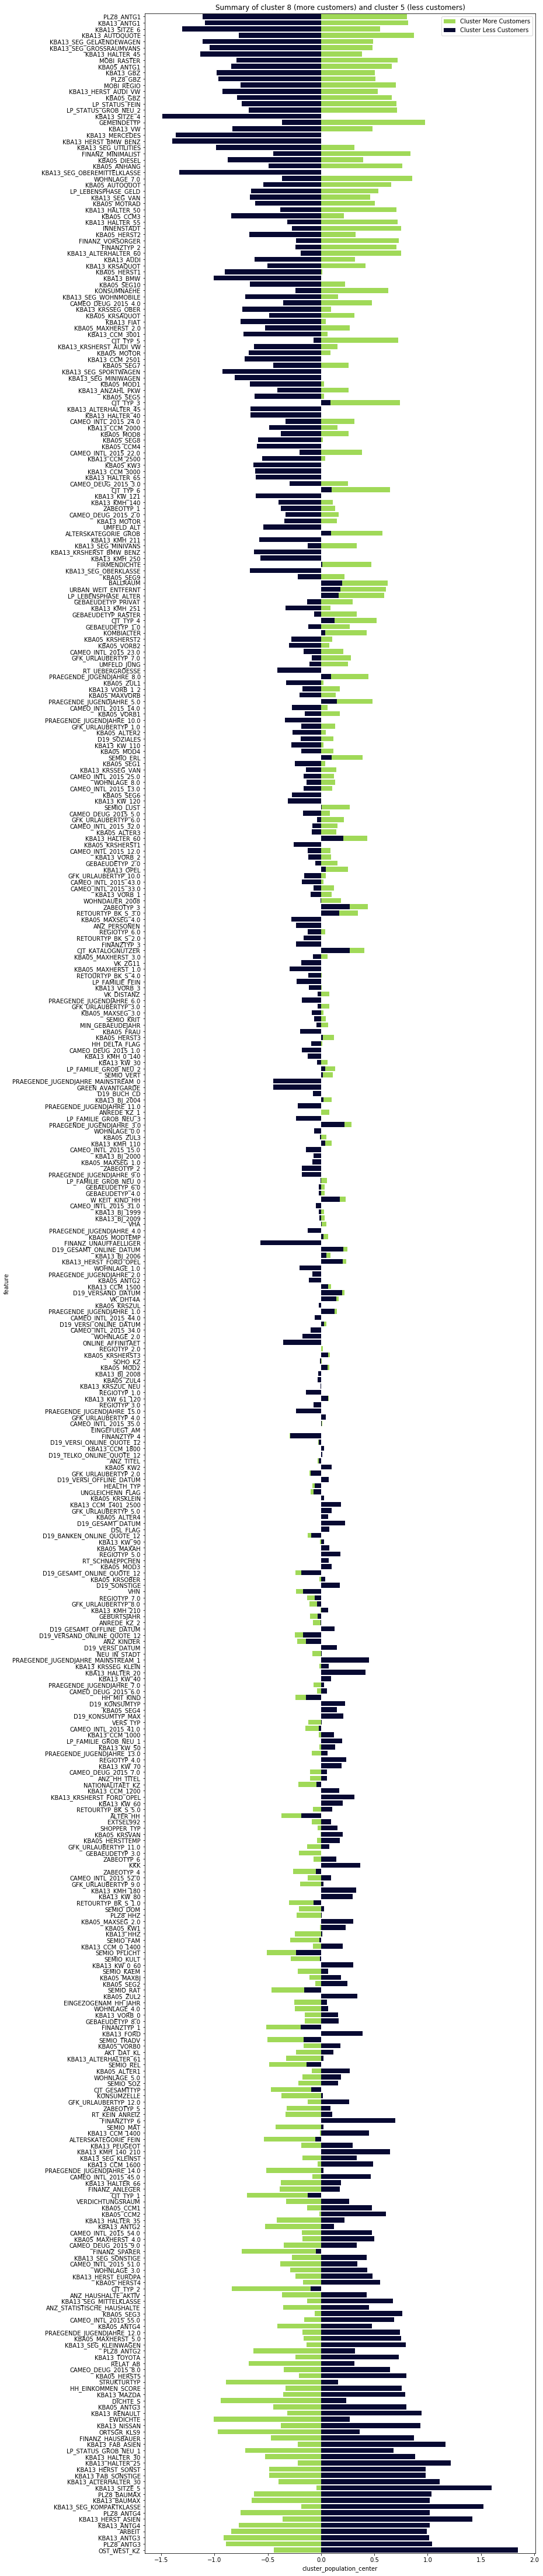

In [152]:
plt.figure(figsize=(12,80))
sns.barplot(data = clusters_8_5, x="cluster_customers_center", y="feature", label="Cluster More Customers", color="#a3ef42")
sns.barplot(data = clusters_8_5, x="cluster_population_center", y="feature", label="Cluster Less Customers", color="#000339")          
plt.legend(loc="upper right")
plt.title("Summary of cluster 8 (more customers) and cluster 5 (less customers)")

In [153]:
clusters_3_4 = get_cluster_feature_summary(3,4)

In [154]:
clusters_3_4.head(20)

,feature,cluster_customers_center,cluster_population_center,diff
0,FINANZ_MINIMALIST,1.096246,-0.905468,2.001713
1,PRAEGENDE_JUGENDJAHRE_MAINSTREAM_0,1.595444,-0.326044,1.921488
2,GREEN_AVANTGARDE,1.595444,-0.326044,1.921488
3,LP_LEBENSPHASE_GELD,1.237761,-0.520812,1.758573
4,CJT_TYP_5,0.741465,-0.881823,1.623288
5,LP_STATUS_GROB_NEU_2,1.054662,-0.556468,1.611129
6,LP_STATUS_FEIN,1.134942,-0.449813,1.584755
7,FINANZ_VORSORGER,0.759816,-0.820261,1.580076
8,ALTERSKATEGORIE_GROB,0.567582,-0.802460,1.370042
9,CJT_TYP_4,0.676958,-0.667414,1.344373


In [155]:
clusters_3_4.tail(10)

,feature,cluster_customers_center,cluster_population_center,diff
398,PRAEGENDE_JUGENDJAHRE_14.0,-0.567336,0.921985,-1.489320
399,FINANZTYP_1,-0.553378,0.984867,-1.538246
400,LP_STATUS_GROB_NEU_1,-1.054662,0.556468,-1.611129
401,HH_EINKOMMEN_SCORE,-1.286621,0.361749,-1.648370
402,CJT_TYP_1,-0.785747,0.952187,-1.737934
403,FINANZ_ANLEGER,-0.872906,0.883116,-1.756022
404,RT_KEIN_ANREIZ,-0.908937,0.864678,-1.773615
405,CJT_TYP_2,-0.829772,0.948006,-1.777778
406,FINANZ_SPARER,-0.864223,1.035025,-1.899248
407,PRAEGENDE_JUGENDJAHRE_MAINSTREAM_1,-1.595444,0.326044,-1.921488


Text(0.5, 1.0, 'Summary of cluster 4 (more customers) and cluster 10 (less customers)')

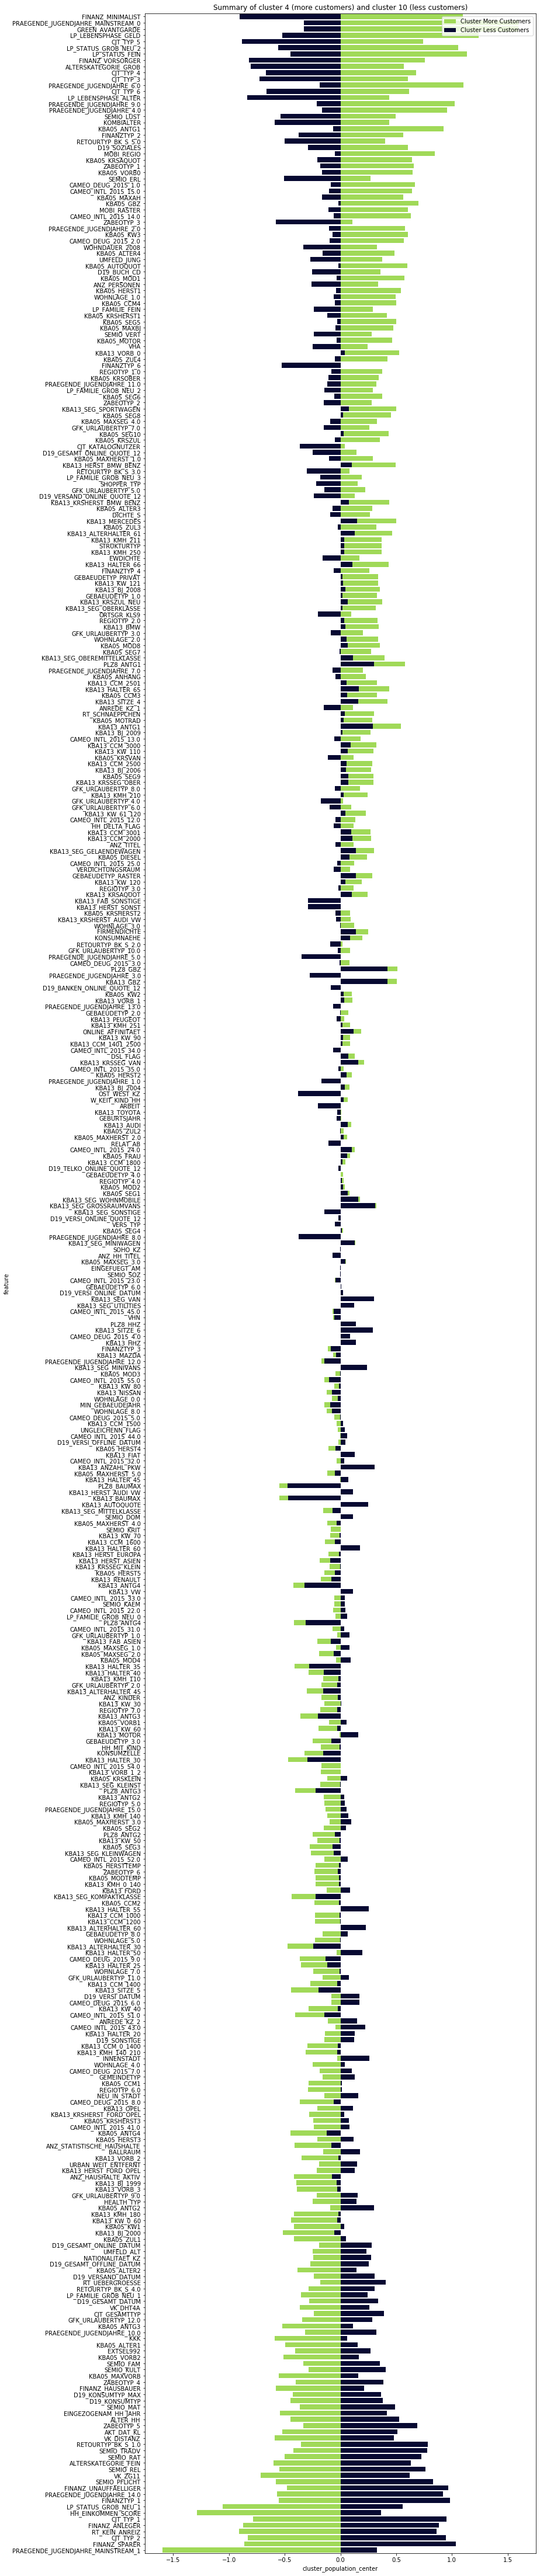

In [156]:
plt.figure(figsize=(12,80))
sns.barplot(data = clusters_3_4, x="cluster_customers_center", y="feature", label="Cluster More Customers", color="#a3ef42")
sns.barplot(data = clusters_3_4, x="cluster_population_center", y="feature", label="Cluster Less Customers", color="#000339")          
plt.legend(loc="upper right")
plt.title("Summary of cluster 4 (more customers) and cluster 10 (less customers)")

From the analysis of two most distinguishing cluster pairs a certain insights can be derived:

Cluster 8 contains customers with for example following characteristics: bigger values (compared to opposite cluster 5) of particular features.
Such differences suggest the company should look for new customers among average earners (LP_STATUS_GROB_NEU_2) living in areas with more 1–2 family homes (PLZ8_ANTG1) and increased number of cars (KBA13_AUTOQUOTE) especially with 6 seats (KBA13_SITZE6). Additionally, lower values of OST_WEST_KZ and FINANZ_HAUSBAUER suggest the potential customers live in the western Germany and their main focus ( financial topology) is placed on their house. Company should not focus too much in acquiring customers among people from eastern Germany with BMW.

Analysis of another cluster pair, 3 (more customers) and 4 (less customers) suggests that more promising prospect can be among customers perceived less as "financial minimalists" compared to the general public and belong to the "green avantgarde" and their youth was shaped in opposition to the mainstream.


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 1. Data preparation

In [157]:
mailout_train = pd.read_csv('../data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/home/jakub/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data ist heavily imbalanced - only 1.2% of individuals in the training set responded to the mailout campaign, as can be inferred from the cells below.

It might be reasonable to conduct an oversampling on the data for the classifier to train on so that the classifier learns to detect both classes.

In [158]:
mailout_train.groupby("RESPONSE").count()["LNR"]

RESPONSE
0    42430
1      532
Name: LNR, dtype: int64

Text(0.5, 1.0, 'Distribution of RESPONSE in training dataset')

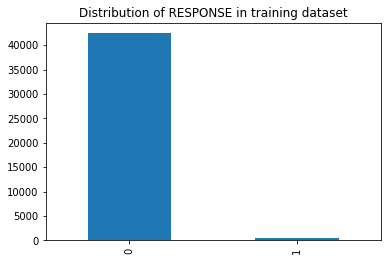

In [159]:
mailout_train.RESPONSE.value_counts().plot.bar() 
plt.title("Distribution of RESPONSE in training dataset")

In [160]:
532/(42430+532)

0.012383036171500396

In [161]:
mailout_train.shape

(42962, 367)

In [162]:
y_training = mailout_train['RESPONSE']

In [163]:
mailout_tr_cp  = mailout_train.copy()

In [164]:
del mailout_tr_cp['RESPONSE']

In [167]:
def clean_and_process_for_modeling(df):
    """ function to preprocess data for supervised learning (based on the steps and functions outlined in the project)
    INPUT: 
        df (pd.DataFrame) - data to process
    OUTPUT:
        df_processed (pd.DataFrame) - processed data
    """
    
    df_processed = df.copy()
    
    #load dumped nan_dict  
    print("Adjusting column types...")
    
    df_processed = change_types(df_processed)
    if "RESPONSE" in df_processed.columns:
        print("Extracting RESPONSE...")
        
        df_processed = df_processed.drop("RESPONSE", axis = 1)

    df_processed = solve_type_and_col_mismatch(df_processed)
    
    print("Encoding missing values as NaNs...")
    df_processed = all_missings_to_nans(df_processed, nan_dict)
#     if scoring == False:
#         print("Removing rows with more than 80% missing values")
#         df_processed = remove_rows_with_too_much_nan(df_processed, 0.8)
        
#         print("checking columns for nan...")
#         summary_of_missings(df_processed, rows = 0)
    
    cols_to_drop = ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'ALTER_KIND2',
        'D19_TELKO_ANZ_12', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL',
        'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL',
        'D19_WEIN_FEINKOST', 'D19_BANKEN_ANZ_12', 'D19_ENERGIE',
        'D19_TELKO_ANZ_24', 'D19_BANKEN_REST', 'D19_VERSI_ANZ_12',
        'D19_TELKO_OFFLINE_DATUM', 'D19_BILDUNG', 'ALTER_KIND1',
        'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL',
        'D19_BANKEN_ANZ_24', 'D19_FREIZEIT', 'D19_BANKEN_GROSS',
        'D19_VERSI_ANZ_24', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST',
        'D19_DROGERIEARTIKEL', 'D19_KINDERARTIKEL', 'D19_LOTTO', 'D19_KOSMETIK',
        'D19_REISEN', 'D19_VERSAND_REST', 'D19_BANKEN_DIREKT',
        'D19_BANKEN_ONLINE_DATUM', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO',
        'D19_BEKLEIDUNG_REST', 'D19_BANKEN_DATUM', 'AGER_TYP',
        'D19_TELKO_DATUM', 'D19_VERSICHERUNGEN',
        'D19_VERSAND_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM', 'D19_TECHNIK',
        'D19_VOLLSORTIMENT', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP',
        'D19_VERSAND_ANZ_24',
        'D19_GESAMT_ANZ_24', 'D19_VERSAND_ONLINE_DATUM', 'KBA05_BAUMAX']
    
    print("Removing unnecessary columns...")
    df_processed = df_processed[[c for c in df_processed.columns if c not in cols_to_drop]] 
    
    print("Imputing NaNs...")
    df_processed = impute_missings(df_processed)
    
    print("Recoding and generating new features...")
    df_processed = process_and_generate_features(df_processed)    

    print("Data preparation done!")
    print("Shape of the processed data", df_processed.shape)
    return df_processed

In [168]:
mailout_tr_cp_cleaned =clean_and_process_for_modeling(mailout_tr_cp)

Adjusting column types...
Mismatched columns  ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] were taken care of.
Column OST_WEST_KZ was recoded
Encoding missing values as NaNs...
Removing unnecessary columns...
Imputing NaNs...
Recoding and generating new features...
Data preparation done!
Shape of the processed data (42962, 408)


In [169]:
print("Scaling features...")
scaler = StandardScaler()
features_list = mailout_tr_cp_cleaned.columns
scaler.fit(mailout_tr_cp_cleaned)
mailout_train_scaled = scaler.transform(mailout_tr_cp_cleaned)
mailout_train_scaled = pd.DataFrame(mailout_train_scaled)
mailout_train_scaled.columns = features_list
print("Table was scaled!")

Scaling features...
Table was scaled!


In [170]:
mailout_train_scaled.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,ZABEOTYP_5,ZABEOTYP_6,LP_STATUS_GROB_NEU_1,LP_STATUS_GROB_NEU_2,LP_FAMILIE_GROB_NEU_0,LP_FAMILIE_GROB_NEU_1,LP_FAMILIE_GROB_NEU_2,LP_FAMILIE_GROB_NEU_3,PRAEGENDE_JUGENDJAHRE_MAINSTREAM_0,PRAEGENDE_JUGENDJAHRE_MAINSTREAM_1
0,-0.274048,-0.871399,-0.428455,0.671637,-0.116979,-0.204857,-0.656284,0.585171,-0.083831,-0.220509,...,-0.083434,-0.203289,0.971089,-0.971089,-0.485978,1.585374,-0.444688,-0.748738,-0.623381,0.623381
1,1.594293,0.418599,0.837103,-0.336522,-0.116979,-0.204857,0.113910,-0.329256,-0.083831,-1.214166,...,-0.083434,-0.203289,-1.029771,1.029771,-0.485978,-0.630766,2.248768,-0.748738,-0.623381,0.623381
2,-0.274048,-0.613399,-0.681567,-0.408533,-0.116979,-0.204857,-1.426478,-0.329256,-0.083831,0.773148,...,-0.083434,-0.203289,-1.029771,1.029771,2.057708,-0.630766,-0.444688,-0.748738,1.604156,-1.604156
3,-0.274048,-1.387398,-0.934679,-0.120488,-0.116979,-0.204857,0.113910,-0.100649,-0.083831,0.773148,...,-0.083434,-0.203289,0.971089,-0.971089,-0.485978,-0.630766,2.248768,-0.748738,1.604156,-1.604156
4,-0.274048,-0.613399,-0.175344,3.408069,-0.116979,-0.204857,-0.656284,2.947442,-0.083831,-0.220509,...,-0.083434,-0.203289,-1.029771,1.029771,-0.485978,1.585374,-0.444688,-0.748738,-0.623381,0.623381


In [171]:
kmeans_model = KMeans(n_clusters=9, random_state=23)

In [172]:
cluster_labels_train = kmeans_model.fit_predict(mailout_train_scaled)


In [175]:
mailout_train_scaled['cluster'] = pd.Series(cluster_labels_train, index=mailout_train_scaled.index)

In [188]:
mailout_train_scaled = pd.get_dummies(mailout_train_scaled, columns = ["cluster"])

In [189]:
mailout_train_scaled.shape

(42962, 417)

In [190]:
mailout_train_scaled.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,PRAEGENDE_JUGENDJAHRE_MAINSTREAM_1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,-0.274048,-0.871399,-0.428455,0.671637,-0.116979,-0.204857,-0.656284,0.585171,-0.083831,-0.220509,...,0.623381,0,0,0,0,0,0,1,0,0
1,1.594293,0.418599,0.837103,-0.336522,-0.116979,-0.204857,0.113910,-0.329256,-0.083831,-1.214166,...,0.623381,0,0,0,1,0,0,0,0,0
2,-0.274048,-0.613399,-0.681567,-0.408533,-0.116979,-0.204857,-1.426478,-0.329256,-0.083831,0.773148,...,-1.604156,0,0,0,0,1,0,0,0,0
3,-0.274048,-1.387398,-0.934679,-0.120488,-0.116979,-0.204857,0.113910,-0.100649,-0.083831,0.773148,...,-1.604156,1,0,0,0,0,0,0,0,0
4,-0.274048,-0.613399,-0.175344,3.408069,-0.116979,-0.204857,-0.656284,2.947442,-0.083831,-0.220509,...,0.623381,1,0,0,0,0,0,0,0,0


### 2. SMOTE

In [191]:
oversampler = SMOTE()

X_train, y_train = oversampler.fit_resample(mailout_train_scaled, y_training)

In [192]:
X_train.shape, y_train.shape

((84860, 417), (84860,))

With SMOTE (Synthetic Minority Over-Sampling Technique) dataset was enriched in such a way that both classes have the same number of occurences in the dataset - the minority class (RESPONSE = 1) has been artificially increased by adding rows with feature values that lie in the neighbourhood of the true observations where RESPONSE equals "1".

Text(0.5, 1.0, 'Distribution of RESPONSE in training dataset after SMOTE')

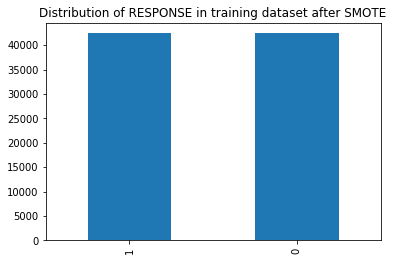

In [193]:
y_train.value_counts().plot.bar()
plt.title("Distribution of RESPONSE in training dataset after SMOTE")

In [194]:
X_train.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,PRAEGENDE_JUGENDJAHRE_MAINSTREAM_1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,-0.274048,-0.871399,-0.428455,0.671637,-0.116979,-0.204857,-0.656284,0.585171,-0.083831,-0.220509,...,0.623381,0,0,0,0,0,0,1,0,0
1,1.594293,0.418599,0.837103,-0.336522,-0.116979,-0.204857,0.113910,-0.329256,-0.083831,-1.214166,...,0.623381,0,0,0,1,0,0,0,0,0
2,-0.274048,-0.613399,-0.681567,-0.408533,-0.116979,-0.204857,-1.426478,-0.329256,-0.083831,0.773148,...,-1.604156,0,0,0,0,1,0,0,0,0
3,-0.274048,-1.387398,-0.934679,-0.120488,-0.116979,-0.204857,0.113910,-0.100649,-0.083831,0.773148,...,-1.604156,1,0,0,0,0,0,0,0,0
4,-0.274048,-0.613399,-0.175344,3.408069,-0.116979,-0.204857,-0.656284,2.947442,-0.083831,-0.220509,...,0.623381,1,0,0,0,0,0,0,0,0


### 3. Test of several models

In this step several models will be tested against the balanced data in order to select the one to use to obtain predictions:
- Logistic Regression
- RandomForest Classifier
- LGMB Classifier
- AdaBoost Classifier
- Gradient Boosting Classifier

As a scoring metric the ROC was chosen.

In [195]:
models = []
models.append(("LogisticRegression",LogisticRegression(max_iter=2000, random_state=23)))
models.append(("RandomForest",RandomForestClassifier(random_state=23)))
models.append(("LGBMClassifier",LGBMClassifier(random_state=23)))
models.append(("AdaBoostClassifier",AdaBoostClassifier(random_state=23)))
models.append(("GradientBoostingClassifierr",GradientBoostingClassifier(random_state=23)))

results = []
names = []
for name,model in models:
    print("Checking", name)
    result = cross_val_score(model, X_train, y_train,  cv=3,  scoring='roc_auc')
    print(result)
    names.append(name)
    results.append(result)


Checking LogisticRegression
[0.9280724  0.9404859  0.93777778]
Checking RandomForest
[0.98865745 0.99391278 0.99409465]
Checking LGBMClassifier
[0.98504893 0.99394387 0.9940595 ]
Checking AdaBoostClassifier
[0.97561269 0.98610832 0.98773202]
Checking GradientBoostingClassifierr
[0.98286365 0.99342    0.99349927]


### 4. Fitting models

In [197]:
try_models = [("LogisticRegression",LogisticRegression(max_iter=2000, random_state=23)), ("LGBMClassifier",LGBMClassifier(random_state=23)), ("AdaBoostClassifier",AdaBoostClassifier(random_state=23))]

In [200]:
models_dict = {}
for name,model in try_models:
    models_dict[f"model_{name}"] = model.fit(X_train, y_train)
    


In [201]:
models_dict



{'model_LogisticRegression': LogisticRegression(max_iter=2000, random_state=23),
 'model_LGBMClassifier': LGBMClassifier(random_state=23),
 'model_AdaBoostClassifier': AdaBoostClassifier(random_state=23)}

In [238]:
#used_model =LGBMClassifier(random_state=23)

In [239]:
#used_model.fit(X_train,y_train) #first submission 0.70

LGBMClassifier(random_state=23)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### 1. Data preparation

In [205]:
mailout_test = pd.read_csv('../data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/home/jakub/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Output of this part has to be a pd.DataFrame containing two columns - "LNR" and predicted score ("Response")

test data has to be scaled using scaler 'scaler' fitted on training data!

In [206]:
IDS = mailout_test["LNR"]


In [207]:
len(IDS)

42833

In [209]:
mailout_test_cleaned = clean_and_process_for_modeling(mailout_test)

Adjusting column types...
Mismatched columns  ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] were taken care of.
Column OST_WEST_KZ was recoded
Encoding missing values as NaNs...
Removing unnecessary columns...
Imputing NaNs...
Recoding and generating new features...
Data preparation done!
Shape of the processed data (42833, 408)


In [210]:
print("Scaling features...")
features_list = mailout_test_cleaned.columns
mailout_test_cleaned = scaler.transform(mailout_test_cleaned)
mailout_test_cleaned = pd.DataFrame(mailout_test_cleaned)
mailout_test_cleaned.columns = features_list
print("Table was scaled!")

Scaling features...
Table was scaled!


In [211]:
cluster_labels_test = kmeans_model.predict(mailout_test_cleaned)
mailout_test_cleaned['cluster'] = pd.Series(cluster_labels_test, index=mailout_test_cleaned.index)

In [212]:
mailout_test_cleaned = pd.get_dummies(mailout_test_cleaned, columns = ["cluster"])

In [213]:
mailout_test_cleaned.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,PRAEGENDE_JUGENDJAHRE_MAINSTREAM_1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,-0.274048,-1.129398,-0.934679,-0.264510,-0.116979,-0.204857,0.113910,-0.253054,-0.083831,-0.220509,...,-1.604156,1,0,0,0,0,0,0,0,0
1,-0.274048,-0.613399,-2.453349,1.031694,-0.116979,-0.204857,-0.656284,1.194789,-0.083831,0.773148,...,0.623381,0,0,1,0,0,0,0,0,0
2,4.708196,1.192598,0.330880,-0.264510,-0.116979,-0.204857,1.654299,-0.253054,-0.083831,0.773148,...,-1.604156,0,0,0,0,1,0,0,0,0
3,3.462635,-0.613399,-2.453349,-0.336522,-0.116979,-0.204857,-1.426478,-0.329256,-0.083831,0.773148,...,0.623381,0,0,0,0,0,0,0,1,0
4,-0.274048,2.482596,0.837103,-0.336522,-0.116979,-0.204857,1.654299,-0.329256,-0.083831,-0.220509,...,0.623381,0,0,0,1,0,0,0,0,0


### 2. Prediction

In [214]:
predictions_dict = {}

In [215]:
for name, model in models_dict.items():
    print("Predictions using", name)
    predictions_dict[name] = model.predict_proba(mailout_test_cleaned)[::,1]



Predictions using model_LogisticRegression
Predictions using model_LGBMClassifier
Predictions using model_AdaBoostClassifier


In [218]:
for v in predictions_dict.values():
    print((v>0.5).sum())

4946
892
2498


In [244]:
predictions  = used_model.predict_proba(mailout_test_cleaned)[::,1]

In [220]:
df_submission = pd.DataFrame(predictions_dict["model_LGBMClassifier"], IDS).reset_index()
df_submission.columns = ["LNR", "RESPONSE"]

In [221]:
df_submission.head()

,LNR,RESPONSE
0,1754,0.033691
1,1770,0.016625
2,1465,0.002551
3,1470,0.003766
4,1478,0.003368


### 3. Export

In [222]:
df_submission.to_csv('submission_5_8.csv', index=False)